Intention of this notebook is to see how the extracted sequence representations (based on the sequences from the T1626 dataset of the Merck&Co+ dataset) from the deep CNN network traned on BacDive+ perform ***on their own***, using the XGBoost with nested bayesian optimization.

For the current nomenclature of these "extracted cnn feature models" see the names in the brackets.

## Notebook Setup

In [0]:
#Imports:
import os
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn import preprocessing
import matplotlib.pyplot as plt
import pickle
from sklearn.model_selection import RepeatedKFold
import time
import datetime
import seaborn as sns

In [0]:
#Connect to google drive:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
#Set up file paths:
data_folder_loc = "gdrive/My Drive/iGEM/Databases/Merck&Co/Data/T1626/cnn_rep_sampler_T1626/"
model_folder_loc = "gdrive/My Drive/iGEM/Databases/Merck&Co/Models/CNN_Features/"
y_target_loc = "gdrive/My Drive/iGEM/Databases/Merck&Co/Data/T1626/own_baseline_xgboost_T1626/" + "y_label_own_baseline_xgboost_T1626.pkl"
X_seq_all_01_loc =  data_folder_loc + "sequence_cnn_rep_all_default_01.csv"
X_seq_diff_01_loc =  data_folder_loc + "sequence_cnn_rep_diff_default_01.csv"
X_seq_all_02_loc =  data_folder_loc + "sequence_cnn_rep_all_default_02.csv"
X_seq_diff_02_loc =  data_folder_loc + "sequence_cnn_rep_diff_default_02.csv"
X_seq_all_03_loc =  data_folder_loc + "sequence_cnn_rep_all_default_03.csv"
X_seq_diff_03_loc =  data_folder_loc + "sequence_cnn_rep_diff_default_03.csv"
X_seq_all_64_loc =  data_folder_loc + "sequence_cnn_rep_all_64_01.csv"
X_seq_diff_64_loc =  data_folder_loc + "sequence_cnn_rep_diff_64_01.csv"
unambiguous_sequence_mut_filter_loc = "gdrive/My Drive/iGEM/Databases/Merck&Co/Data/T1626/sequence_sampler_T1626/unambiguous_mut_filter_T1626.csv"

pretrain_cont_result_table_loc = "gdrive/My Drive/iGEM/Databases/Merck&Co/Models/CNN_Features_Pretrain_Cont/pretrain_cont_results_table.csv"

print("Folders: ")
print("\t",os.path.isdir(data_folder_loc))
print("\t",os.path.isdir(model_folder_loc))
print("Files: ")
print("\t",os.path.isfile(y_target_loc))
print("\t",os.path.isfile(X_seq_all_01_loc))
print("\t",os.path.isfile(X_seq_diff_01_loc))
print("\t",os.path.isfile(X_seq_all_02_loc))
print("\t",os.path.isfile(X_seq_diff_02_loc))
print("\t",os.path.isfile(X_seq_all_03_loc))
print("\t",os.path.isfile(X_seq_diff_03_loc))
print("\t",os.path.isfile(X_seq_all_64_loc))
print("\t",os.path.isfile(X_seq_diff_64_loc))
print("\t",os.path.isfile(unambiguous_sequence_mut_filter_loc))
print("\t",os.path.isfile(pretrain_cont_result_table_loc))

Folders: 
	 True
	 True
Files: 
	 True
	 True
	 True
	 True
	 True
	 True
	 True
	 True
	 True
	 True
	 True


In [0]:
#XGBoost
!pip install xgboost==0.82 #working GPU support
import xgboost as xgb

In [0]:
#BayersianOptimization
!pip install bayesian-optimization
from bayes_opt import BayesianOptimization

## Prepare Data

In [0]:
#Just load data
y_label = pd.read_pickle(y_target_loc) 
X_seq_all_01 = pd.read_csv(X_seq_all_01_loc, index_col=0)
X_seq_diff_01 = pd.read_csv(X_seq_diff_01_loc, index_col=0)
X_seq_all_02 = pd.read_csv(X_seq_all_02_loc, index_col=0)
X_seq_diff_02 = pd.read_csv(X_seq_diff_02_loc, index_col=0)
X_seq_all_03 = pd.read_csv(X_seq_all_03_loc, index_col=0)
X_seq_diff_03 = pd.read_csv(X_seq_diff_03_loc, index_col=0)
X_seq_all_64 = pd.read_csv(X_seq_all_64_loc, index_col=0)
X_seq_diff_64 = pd.read_csv(X_seq_diff_64_loc, index_col=0)
unambiguous_mut_filter = pd.read_csv(unambiguous_sequence_mut_filter_loc)["Unambiguous"].values
pretrain_cont_result_table =  pd.read_csv(pretrain_cont_result_table_loc)

In [0]:
X_seq_all_01_02_03 = pd.concat([X_seq_all_01, X_seq_all_02, X_seq_all_03], axis=1)
X_seq_diff_01_02_03 = pd.concat([X_seq_diff_01, X_seq_diff_02, X_seq_diff_03], axis=1)

In [0]:
X_seq_diff_01_02_03.head()

,diff_rep_0,diff_rep_1,diff_rep_2,diff_rep_3,diff_rep_4,diff_rep_5,diff_rep_6,diff_rep_7,diff_rep_8,diff_rep_9,diff_rep_10,diff_rep_11,diff_rep_12,diff_rep_13,diff_rep_14,diff_rep_15,diff_rep_16,diff_rep_17,diff_rep_18,diff_rep_19,diff_rep_20,diff_rep_21,diff_rep_22,diff_rep_23,diff_rep_24,diff_rep_25,diff_rep_26,diff_rep_27,diff_rep_28,diff_rep_29,diff_rep_30,diff_rep_31,diff_rep_32,diff_rep_33,diff_rep_34,diff_rep_35,diff_rep_36,diff_rep_37,diff_rep_38,diff_rep_39,...,diff_rep_728,diff_rep_729,diff_rep_730,diff_rep_731,diff_rep_732,diff_rep_733,diff_rep_734,diff_rep_735,diff_rep_736,diff_rep_737,diff_rep_738,diff_rep_739,diff_rep_740,diff_rep_741,diff_rep_742,diff_rep_743,diff_rep_744,diff_rep_745,diff_rep_746,diff_rep_747,diff_rep_748,diff_rep_749,diff_rep_750,diff_rep_751,diff_rep_752,diff_rep_753,diff_rep_754,diff_rep_755,diff_rep_756,diff_rep_757,diff_rep_758,diff_rep_759,diff_rep_760,diff_rep_761,diff_rep_762,diff_rep_763,diff_rep_764,diff_rep_765,diff_rep_766,diff_rep_767
Mutation,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1AKY@A@I213F,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,-0.063452,0.000000,0.000000,0.345296,0.000000,0.000000,0.000000,0.000000,-0.051311,0.000000,0.000000,0.000000,0.000000,-0.163934,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.001523,0.000000,-0.001606,0.000000,-0.277752,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.042222,0.000000,-0.206137,0.000000
1AKY@A@N169D,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.135772,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.012303,0.336062,0.000000,0.000000,0.000000,0.000000,0.001812,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.063004,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,-0.001237,0.000000,0.000000,0.000000,0.000000,0.000000,-0.025286,0.000000,0.000000,0.000000
1AKY@A@Q48E,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,-0.572438,0.063372,0.000000,-0.341408,0.053894,0.348088,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.420903,0.000000,0.0,0.103690,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.098217,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.040153,0.114376,0.000000,0.000000,0.000000
1AKY@A@T110H,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.261823,0.078858,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.124731,-0.011780,-0.003999,0.136516,0.000000,-0.201293,0.000000,-0.153837,0.0,-0.022995,-0.007815,0.000000,0.000000,0.000000,0.066218,0.000000,-0.154907,0.000000,-0.01932,0.000000,0.000000,0.068523,-0.103127,0.009915,0.000000,0.000000,0.000000,0.000000,0.040680
1AKY@A@T77H,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,-0.036989,0.000000,0.000000,0.000000,0.065008,0.000000,0.000000,0.000000,0.057740,-0.010517,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.172975,0.000000,0.074728,0.000000,-0.223700,0.000000,0.039526,0.000000,0.00000,0.000000,0.011059,0.000000,0.000000,-0.080509,0.000000,0.000000,0.239078,0.000000,0.303034


## Supplementary functions

In [0]:
def n_trial_nested_k_fold_crossvalidation(data_x, data_y, num_trials=7, eval_metric="mae", scale_label=False, inner_fold=3, outer_fold=5, bayes_init_points=15, bayes_iterations=10, bayes_acquisition_function='ei', repeated_k_fold_seed=42375):  
  print("Trials: ", num_trials)
  print("Evaluation metric: ", eval_metric)
  print("Inner folds: ", inner_fold)
  print("Outer folds: ", outer_fold)
  print("Bayesian init points: ", bayes_init_points)
  print("Bayesian iterations: ", bayes_iterations)
  print("Bayes acquisition function: ", bayes_acquisition_function)

  # Variable for xgb_evalutate, unfortunately cannot be a direct argument
  bayesian_training_data = None
  # Supplementary function for hyperparameter tuning. Corresponds in essense to inner cross validation.
  def xgb_evaluate(max_depth, gamma, colsample_bytree, subsample, eta):
      params = {'eval_metric': eval_metric,
                'objective':'reg:linear',
                'tree_method': 'gpu_hist',
                'max_depth': int(max_depth),
                'eta': eta,
                'gamma': gamma,
                'colsample_bytree': colsample_bytree,
                'subsample': subsample}
      # This corresponds to the inner cross validation cycle for hyperparameter tuning:
      cv_result = xgb.cv(params, bayesian_training_data, num_boost_round=100, nfold=inner_fold)    
      # Bayesian optimization only knows how to maximize, not minimize, thus negate score:
      return -1.0 * cv_result['test-mae-mean'].iloc[-1]
    
  # Bounds for the bayesian optimization
  bay_bounds={'eta': (0.01, 0.3),
              'max_depth': (5, 10), 
              'gamma': (0.0, 1.0),
              'colsample_bytree': (0.5, 1.0),
              'subsample': (0.7, 1.0)}
    
  #saves result for each outer cross val
  scores_mae = [] 
  scores_rmse = []
  best_parameters = []

  total_fold_counter = 0
  rkf = RepeatedKFold(n_splits=outer_fold, n_repeats=num_trials, random_state=repeated_k_fold_seed)
  # Main loop for trials and outer outer cross_val
  for train_index, test_index in rkf.split(data_x):
    #Measure runtime
    start_time = time.time()
    
    # Print current status
    print("\nTrial number: ", (total_fold_counter//outer_fold)+1)
    print("Fold number: ", (total_fold_counter%outer_fold)+1)
    total_fold_counter += 1
    
    # Select current train and test data
    X_train, X_test = data_x[train_index], data_x[test_index]
    y_train, y_test = data_y[train_index], data_y[test_index]
    
    # Scale target label, if requested
    standard_scaler = preprocessing.StandardScaler()
    if scale_label:
      y_train = standard_scaler.fit_transform(y_train.reshape(-1, 1)).reshape((len(y_train))) #only fit on y_train to prevent information leakage
    
    # Prepare data for XGBoost
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test)
    
    # Bayesian optimize in 5 fold cross validation
    xgb_bo = BayesianOptimization(f=xgb_evaluate, 
                                  pbounds=bay_bounds,
                                  random_state=((total_fold_counter*repeated_k_fold_seed)%1000)) #create deterministic seed from outer_fold, num_trials and repeated_k_fold_seed
    bayesian_training_data = dtrain
    xgb_bo.maximize(init_points=bayes_init_points, n_iter=bayes_iterations, acq=bayes_acquisition_function) #default: 20,20,'ei'
    
    # Extract optimal parameters
    params_opt = xgb_bo.max['params']
    best_parameters.append(params_opt) #save best parameters
    params_opt['max_depth'] = int(params_opt['max_depth'])
    params_opt['eval_metric'] = eval_metric
    params_opt['objective'] = 'reg:linear'
    params_opt['tree_method'] = 'gpu_hist'
    
    # Train a new model with the best parameters from the search
    model = xgb.train(params_opt, dtrain, num_boost_round=1000)

    # Predict on testing set
    y_pred = model.predict(dtest)
    if scale_label:
      y_pred = standard_scaler.inverse_transform(y_pred.reshape(-1, 1))

    # Report testing and training scores
    scores_mae.append(mean_absolute_error(y_test, y_pred))
    scores_rmse.append(np.sqrt(mean_squared_error(y_test, y_pred)))
    print("MAE: ", scores_mae[-1], " RMSE: ",scores_rmse[-1], " Runtime: ", str(datetime.timedelta(seconds=(time.time()-start_time))))
  
  print()
  results = pd.DataFrame(best_parameters)
  results["scores_mae"] = scores_mae
  results["scores_rmse"] = scores_rmse
  return results

In [0]:
def plot_results_bar_err(results_df, std_df, title, saveloc, fig_size=(7,6), fig_lim=(2,6)):
  sns.set()
  fig, ax = plt.subplots(figsize=fig_size)
  plt.ylim(fig_lim[0], fig_lim[1])
  results_df.plot.bar(yerr=std_df, ax=ax, color=["lightslategray","lightsteelblue"], title=title, rot=45, width=.7, error_kw=dict(ecolor='dimgrey', lw=1.5, capsize=4, capthick=1.5))
  ax.xaxis.grid(False)
  plt.tight_layout()
  plt.savefig(saveloc, dpi=300)
  plt.show()

## Evaluate different models

### Model default_cnn_all_01: (A1)

In [0]:
model_cnn_all_01_results = n_trial_nested_k_fold_crossvalidation(X_seq_all_01.values, y_label.values)

Trials:  7
Evaluation metric:  mae
Inner folds:  3
Outer folds:  5
Bayesian init points:  15
Bayesian iterations:  10
Bayes acquisition function:  ei

Trial number:  1
Fold number:  1
|   iter    |  target   | colsam... |    eta    |   gamma   | max_depth | subsample |
-------------------------------------------------------------------------------------
|  1        | -3.424    |  0.6016   |  0.03383  |  0.0537   |  7.328    |  0.7635   |
|  2        | -3.54     |  0.7643   |  0.2832   |  0.2935   |  5.067    |  0.8559   |
|  3        | -3.557    |  0.9518   |  0.2416   |  0.7593   |  5.313    |  0.7975   |
|  4        | -3.592    |  0.5583   |  0.01254  |  0.4712   |  5.634    |  0.8909   |
|  5        | -3.576    |  0.697    |  0.2568   |  0.6236   |  9.847    |  0.8862   |
|  6        | -3.433    |  0.8253   |  0.07749  |  0.3247   |  8.73     |  0.8518   |
|  7        | -3.442    |  0.636    |  0.1644   |  0.882    |  8.065    |  0.8558   |
|  8        | -3.465    |  0.8363   |  0.1

In [0]:
model_cnn_all_01_results.describe()

,colsample_bytree,eta,gamma,max_depth,subsample,scores_mae,scores_rmse
count,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000
mean,0.673666,0.059035,0.517030,7.942857,0.861976,3.370267,4.529392
std,0.115443,0.029407,0.336595,0.905631,0.074871,0.156376,0.222635
min,0.543565,0.015863,0.053701,6.000000,0.721651,3.011676,3.880807
25%,0.586535,0.038415,0.243991,7.000000,0.799472,3.301924,4.409665
50%,0.638553,0.051572,0.414122,8.000000,0.880416,3.353791,4.532046
75%,0.789941,0.070530,0.881517,9.000000,0.916207,3.455938,4.651463
max,0.990882,0.148239,0.979590,9.000000,0.970161,3.785768,5.035682


In [0]:
model_cnn_all_01_results.to_csv(model_folder_loc+"results_default_cnn_all_01_xgboost_T1626.csv")

### Model default_cnn_all_02: (A2)

In [0]:
model_cnn_all_02_results = n_trial_nested_k_fold_crossvalidation(X_seq_all_02.values, y_label.values)

Trials:  7
Evaluation metric:  mae
Inner folds:  3
Outer folds:  5
Bayesian init points:  15
Bayesian iterations:  10
Bayes acquisition function:  ei

Trial number:  1
Fold number:  1
|   iter    |  target   | colsam... |    eta    |   gamma   | max_depth | subsample |
-------------------------------------------------------------------------------------
|  1        | -3.296    |  0.6016   |  0.03383  |  0.0537   |  7.328    |  0.7635   |
|  2        | -3.471    |  0.7643   |  0.2832   |  0.2935   |  5.067    |  0.8559   |
|  3        | -3.492    |  0.9518   |  0.2416   |  0.7593   |  5.313    |  0.7975   |
|  4        | -3.503    |  0.5583   |  0.01254  |  0.4712   |  5.634    |  0.8909   |
|  5        | -3.376    |  0.697    |  0.2568   |  0.6236   |  9.847    |  0.8862   |
|  6        | -3.331    |  0.8253   |  0.07749  |  0.3247   |  8.73     |  0.8518   |
|  7        | -3.377    |  0.636    |  0.1644   |  0.882    |  8.065    |  0.8558   |
|  8        | -3.268    |  0.8363   |  0.1

In [0]:
model_cnn_all_02_results.describe()

,colsample_bytree,eta,gamma,max_depth,subsample,scores_mae,scores_rmse
count,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000
mean,0.699899,0.068898,0.451966,8.057143,0.859874,3.207712,4.355914
std,0.117352,0.030640,0.291086,0.905631,0.071250,0.134344,0.207330
min,0.533868,0.030529,0.053701,6.000000,0.721651,2.809214,3.695015
25%,0.605365,0.044341,0.261321,7.500000,0.799472,3.124565,4.249078
50%,0.638553,0.063494,0.393912,8.000000,0.880416,3.196758,4.347033
75%,0.807796,0.077492,0.644055,9.000000,0.916207,3.286811,4.478348
max,0.988230,0.154447,0.976761,9.000000,0.970161,3.485387,4.847959


In [0]:
model_cnn_all_02_results.to_csv(model_folder_loc+"results_default_cnn_all_02_xgboost_T1626.csv")

### Model default_cnn_all_03: (A3)

In [0]:
model_cnn_all_03_results = n_trial_nested_k_fold_crossvalidation(X_seq_all_03.values, y_label.values)

Trials:  7
Evaluation metric:  mae
Inner folds:  3
Outer folds:  5
Bayesian init points:  15
Bayesian iterations:  10
Bayes acquisition function:  ei

Trial number:  1
Fold number:  1
|   iter    |  target   | colsam... |    eta    |   gamma   | max_depth | subsample |
-------------------------------------------------------------------------------------
|  1        | -3.21     |  0.6016   |  0.03383  |  0.0537   |  7.328    |  0.7635   |
|  2        | -3.331    |  0.7643   |  0.2832   |  0.2935   |  5.067    |  0.8559   |
|  3        | -3.316    |  0.9518   |  0.2416   |  0.7593   |  5.313    |  0.7975   |
|  4        | -3.435    |  0.5583   |  0.01254  |  0.4712   |  5.634    |  0.8909   |
|  5        | -3.282    |  0.697    |  0.2568   |  0.6236   |  9.847    |  0.8862   |
|  6        | -3.153    |  0.8253   |  0.07749  |  0.3247   |  8.73     |  0.8518   |
|  7        | -3.212    |  0.636    |  0.1644   |  0.882    |  8.065    |  0.8558   |
|  8        | -3.191    |  0.8363   |  0.1

In [0]:
model_cnn_all_03_results.describe()

,colsample_bytree,eta,gamma,max_depth,subsample,scores_mae,scores_rmse
count,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000
mean,0.730548,0.076150,0.521551,8.257143,0.862460,3.020594,4.151499
std,0.138912,0.033205,0.295820,0.918530,0.075746,0.153916,0.218680
min,0.550706,0.030529,0.000000,5.000000,0.700000,2.719035,3.683148
25%,0.605365,0.056826,0.324713,8.000000,0.811935,2.915559,4.031846
50%,0.752707,0.070476,0.414122,8.000000,0.889320,3.020554,4.108907
75%,0.821125,0.089072,0.782172,9.000000,0.914156,3.140977,4.278794
max,0.990882,0.162371,0.979590,9.000000,0.996857,3.453749,4.765725


In [0]:
model_cnn_all_03_results.to_csv(model_folder_loc+"results_default_cnn_all_03_xgboost_T1626.csv")

### Model 64_cnn_all_01: //Not in thesis, incompatible taxonomy

In [0]:
model_cnn_all_64_01_results = n_trial_nested_k_fold_crossvalidation(X_seq_all_64.values, y_label.values)

Trials:  7
Evaluation metric:  mae
Inner folds:  3
Outer folds:  5
Bayesian init points:  15
Bayesian iterations:  10
Bayes acquisition function:  ei

Trial number:  1
Fold number:  1
|   iter    |  target   | colsam... |    eta    |   gamma   | max_depth | subsample |
-------------------------------------------------------------------------------------
|  1        | -3.536    |  0.6016   |  0.03383  |  0.0537   |  7.328    |  0.7635   |
|  2        | -3.775    |  0.7643   |  0.2832   |  0.2935   |  5.067    |  0.8559   |
|  3        | -3.812    |  0.9518   |  0.2416   |  0.7593   |  5.313    |  0.7975   |
|  4        | -3.659    |  0.5583   |  0.01254  |  0.4712   |  5.634    |  0.8909   |
|  5        | -3.692    |  0.697    |  0.2568   |  0.6236   |  9.847    |  0.8862   |
|  6        | -3.588    |  0.8253   |  0.07749  |  0.3247   |  8.73     |  0.8518   |
|  7        | -3.66     |  0.636    |  0.1644   |  0.882    |  8.065    |  0.8558   |
|  8        | -3.605    |  0.8363   |  0.1

In [0]:
model_cnn_all_64_01_results.describe()

,colsample_bytree,eta,gamma,max_depth,subsample,scores_mae,scores_rmse
count,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000
mean,0.671326,0.033620,0.473649,7.314286,0.853073,3.505535,4.701656
std,0.108824,0.013764,0.352561,1.231246,0.087867,0.108799,0.160394
min,0.523266,0.012632,0.007143,5.000000,0.700699,3.242163,4.149475
25%,0.578656,0.027291,0.136204,7.000000,0.763481,3.451044,4.617686
50%,0.638553,0.030558,0.393912,7.000000,0.880416,3.497575,4.722486
75%,0.760672,0.040438,0.832620,8.000000,0.928993,3.570813,4.801846
max,0.847584,0.070476,0.994690,9.000000,0.970161,3.679525,5.012543


In [0]:
model_cnn_all_64_01_results.to_csv(model_folder_loc+"results_64_cnn_all_01_xgboost_T1626.csv")

### Model default_cnn_diff_01: (D1)

In [0]:
model_cnn_diff_01_results = n_trial_nested_k_fold_crossvalidation(X_seq_diff_01.values, y_label.values)

Trials:  7
Evaluation metric:  mae
Inner folds:  3
Outer folds:  5
Bayesian init points:  15
Bayesian iterations:  10
Bayes acquisition function:  ei

Trial number:  1
Fold number:  1
|   iter    |  target   | colsam... |    eta    |   gamma   | max_depth | subsample |
-------------------------------------------------------------------------------------
|  1        | -3.495    |  0.6016   |  0.03383  |  0.0537   |  7.328    |  0.7635   |
|  2        | -3.695    |  0.7643   |  0.2832   |  0.2935   |  5.067    |  0.8559   |
|  3        | -3.654    |  0.9518   |  0.2416   |  0.7593   |  5.313    |  0.7975   |
|  4        | -3.686    |  0.5583   |  0.01254  |  0.4712   |  5.634    |  0.8909   |
|  5        | -3.644    |  0.697    |  0.2568   |  0.6236   |  9.847    |  0.8862   |
|  6        | -3.521    |  0.8253   |  0.07749  |  0.3247   |  8.73     |  0.8518   |
|  7        | -3.565    |  0.636    |  0.1644   |  0.882    |  8.065    |  0.8558   |
|  8        | -3.595    |  0.8363   |  0.1

In [0]:
model_cnn_diff_01_results.describe()

,colsample_bytree,eta,gamma,max_depth,subsample,scores_mae,scores_rmse
count,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000
mean,0.677833,0.061658,0.444538,7.742857,0.864180,3.459877,4.663660
std,0.112829,0.031078,0.331338,0.980482,0.083038,0.150189,0.211770
min,0.514375,0.012632,0.053701,6.000000,0.700699,3.190600,4.155156
25%,0.586535,0.038415,0.189157,7.000000,0.799472,3.359909,4.522231
50%,0.638553,0.051572,0.357340,8.000000,0.880416,3.459195,4.673356
75%,0.800786,0.083479,0.784545,8.500000,0.921401,3.577572,4.824443
max,0.891300,0.154447,0.994690,9.000000,0.988668,3.831838,5.135138


In [0]:
model_cnn_diff_01_results.to_csv(model_folder_loc+"results_default_cnn_diff_01_xgboost_T1626.csv")

### Model default_cnn_all_01_filtered: (A1_f)

**To see what happens if I remove the ambiguous protein mutations; 80 in total.**

In [0]:
ambiguous_offset_seq = ["1YEA", "3KS3", "1BNI", "1TPK", "4BLM", "1AYF"]

In [0]:
ambiguous_offset_seq_filter = list(map(lambda x: not(x.split("@")[0].split("_")[0] in ambiguous_offset_seq), X_seq_all_01.index))

In [0]:
X_seq_all_01_filtered = X_seq_all_01[ambiguous_offset_seq_filter]
y_label_filtered = y_label[ambiguous_offset_seq_filter]

In [0]:
print(X_seq_all_01.shape)
print(X_seq_all_01_filtered.shape)
print(y_label_filtered.shape)

(1626, 1536)
(1546, 1536)
(1546,)


In [0]:
X_seq_all_01_filtered_results = n_trial_nested_k_fold_crossvalidation(X_seq_all_01_filtered.values, y_label_filtered.values) 

Trials:  7
Evaluation metric:  mae
Inner folds:  3
Outer folds:  5
Bayesian init points:  15
Bayesian iterations:  10
Bayes acquisition function:  ei

Trial number:  1
Fold number:  1
|   iter    |  target   | colsam... |    eta    |   gamma   | max_depth | subsample |
-------------------------------------------------------------------------------------
|  1        | -3.386    |  0.6016   |  0.03383  |  0.0537   |  7.328    |  0.7635   |
|  2        | -3.608    |  0.7643   |  0.2832   |  0.2935   |  5.067    |  0.8559   |
|  3        | -3.561    |  0.9518   |  0.2416   |  0.7593   |  5.313    |  0.7975   |
|  4        | -3.565    |  0.5583   |  0.01254  |  0.4712   |  5.634    |  0.8909   |
|  5        | -3.466    |  0.697    |  0.2568   |  0.6236   |  9.847    |  0.8862   |
|  6        | -3.387    |  0.8253   |  0.07749  |  0.3247   |  8.73     |  0.8518   |
|  7        | -3.458    |  0.636    |  0.1644   |  0.882    |  8.065    |  0.8558   |
|  8        | -3.414    |  0.8363   |  0.1

In [0]:
X_seq_all_01_filtered_results.describe()

,Unnamed: 0,colsample_bytree,eta,gamma,max_depth,subsample,scores_mae,scores_rmse
count,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000
mean,17.000000,0.692358,0.061417,0.509672,8.057143,0.865646,3.300612,4.472187
std,10.246951,0.134488,0.030540,0.300811,0.802308,0.079123,0.168309,0.245293
min,0.000000,0.543565,0.015863,0.053701,7.000000,0.721651,2.854676,3.843815
25%,8.500000,0.586535,0.039426,0.261321,7.000000,0.799472,3.212009,4.303481
50%,17.000000,0.638553,0.056826,0.414122,8.000000,0.889320,3.301501,4.415136
75%,25.500000,0.819961,0.074011,0.716548,9.000000,0.916207,3.409593,4.642451
max,34.000000,0.990882,0.154447,0.979590,9.000000,0.981605,3.661349,4.945132


In [0]:
X_seq_all_01_filtered_results.to_csv(model_folder_loc+"results_default_cnn_all_01_filtered_xgboost_T1626.csv")

### Model default_cnn_all_01_02_03: (A13)

In [0]:
model_cnn_all_01_02_03_results = n_trial_nested_k_fold_crossvalidation(X_seq_all_01_02_03.values, y_label.values)

Trials:  7
Evaluation metric:  mae
Inner folds:  3
Outer folds:  5
Bayesian init points:  15
Bayesian iterations:  10
Bayes acquisition function:  ei

Trial number:  1
Fold number:  1
|   iter    |  target   | colsam... |    eta    |   gamma   | max_depth | subsample |
-------------------------------------------------------------------------------------
|  1        | -3.211    |  0.6016   |  0.03383  |  0.0537   |  7.328    |  0.7635   |
|  2        | -3.32     |  0.7643   |  0.2832   |  0.2935   |  5.067    |  0.8559   |
|  3        | -3.258    |  0.9518   |  0.2416   |  0.7593   |  5.313    |  0.7975   |
|  4        | -3.433    |  0.5583   |  0.01254  |  0.4712   |  5.634    |  0.8909   |
|  5        | -3.361    |  0.697    |  0.2568   |  0.6236   |  9.847    |  0.8862   |
|  6        | -3.122    |  0.8253   |  0.07749  |  0.3247   |  8.73     |  0.8518   |
|  7        | -3.235    |  0.636    |  0.1644   |  0.882    |  8.065    |  0.8558   |
|  8        | -3.153    |  0.8363   |  0.1

In [0]:
model_cnn_all_01_02_03_results.describe()

,colsample_bytree,eta,gamma,max_depth,subsample,scores_mae,scores_rmse
count,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000
mean,0.719919,0.073599,0.518347,8.142857,0.857762,3.052349,4.175051
std,0.124942,0.026723,0.288289,0.879266,0.069487,0.133152,0.198492
min,0.550706,0.030529,0.075318,6.000000,0.721651,2.782075,3.719038
25%,0.609526,0.059969,0.307466,8.000000,0.809113,2.992403,4.039973
50%,0.706322,0.070530,0.414122,8.000000,0.871250,3.043755,4.175443
75%,0.823696,0.084040,0.782172,9.000000,0.914156,3.132803,4.289273
max,0.990882,0.154447,0.979590,9.000000,0.981605,3.372713,4.554335


In [0]:
model_cnn_all_01_02_03_results.to_csv(model_folder_loc+"results_default_cnn_all_01_02_03_xgboost_T1626.csv")

### Model default_cnn_all_01_02_03 filtered: (A13_f)

In [0]:
model_cnn_all_01_02_03_filtered_results = n_trial_nested_k_fold_crossvalidation(X_seq_all_01_02_03[unambiguous_mut_filter].values, y_label[unambiguous_mut_filter].values)

Trials:  7
Evaluation metric:  mae
Inner folds:  3
Outer folds:  5
Bayesian init points:  15
Bayesian iterations:  10
Bayes acquisition function:  ei

Trial number:  1
Fold number:  1
|   iter    |  target   | colsam... |    eta    |   gamma   | max_depth | subsample |
-------------------------------------------------------------------------------------
|  1        | -3.224    |  0.6016   |  0.03383  |  0.0537   |  7.328    |  0.7635   |
|  2        | -3.28     |  0.7643   |  0.2832   |  0.2935   |  5.067    |  0.8559   |
|  3        | -3.326    |  0.9518   |  0.2416   |  0.7593   |  5.313    |  0.7975   |
|  4        | -3.421    |  0.5583   |  0.01254  |  0.4712   |  5.634    |  0.8909   |
|  5        | -3.322    |  0.697    |  0.2568   |  0.6236   |  9.847    |  0.8862   |
|  6        | -3.211    |  0.8253   |  0.07749  |  0.3247   |  8.73     |  0.8518   |
|  7        | -3.221    |  0.636    |  0.1644   |  0.882    |  8.065    |  0.8558   |
|  8        | -3.219    |  0.8363   |  0.1

In [0]:
model_cnn_all_01_02_03_filtered_results.describe()

,colsample_bytree,eta,gamma,max_depth,subsample,scores_mae,scores_rmse
count,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000
mean,0.747786,0.082059,0.465462,8.171429,0.852131,3.008417,4.115874
std,0.120811,0.030911,0.278981,0.954424,0.071077,0.142156,0.223138
min,0.533868,0.030558,0.052595,6.000000,0.721651,2.596983,3.495408
25%,0.643011,0.065087,0.276166,7.500000,0.799281,2.929310,3.980612
50%,0.784251,0.077492,0.370601,8.000000,0.851849,3.027428,4.093862
75%,0.822536,0.092901,0.644055,9.000000,0.910493,3.096143,4.277268
max,0.990882,0.154447,0.979590,9.000000,0.981605,3.339924,4.623940


In [0]:
model_cnn_all_01_02_03_filtered_results.to_csv(model_folder_loc+"results_default_cnn_all_01_02_03_filtered_xgboost_T1626.csv")

##Results


### Visualization


In [0]:
pretrain_cont_result_table.describe()

,Unnamed: 0,scores_mae,scores_rmse
count,35.000000,35.000000,35.000000
mean,17.000000,3.705597,4.968560
std,10.246951,0.170001,0.245597
min,0.000000,3.399547,4.529309
25%,8.500000,3.569561,4.777363
50%,17.000000,3.713882,4.961233
75%,25.500000,3.840561,5.176313
max,34.000000,3.975770,5.345837


In [0]:
model = ["NN_cont_cnn_all_01-03","cnn_all_01","cnn_all_02","cnn_all_03","cnn_all_01_64","cnn_diff_01","cnn_all_01_f","cnn_all_01-03","cnn_all_01-03_f"]
value = [[3.705597,4.968560],
         [3.370267,4.529392],
         [3.207712,4.355914],
         [3.020594,4.151499],
         [3.505535,4.701656],
         [3.459877,4.663660],
         [3.300612,4.472187],
         [3.052349,4.175051],
         [3.008417,4.115874]]
std = [[0.170001,0.245597],
       [0.156376,0.222635],
       [0.134344,0.207330],
       [0.153916,0.218680],
       [0.108799,0.160394],
       [0.150189,0.211770],
       [0.168309,0.245293],
       [0.133152,0.198492],
       [0.142156,0.223138]]
measure = ["MAE","RMSE"]

values_df = pd.DataFrame(value)
values_df.columns=measure
values_df.index=model

std_df = pd.DataFrame(std)
std_df.columns=measure
std_df.index=model

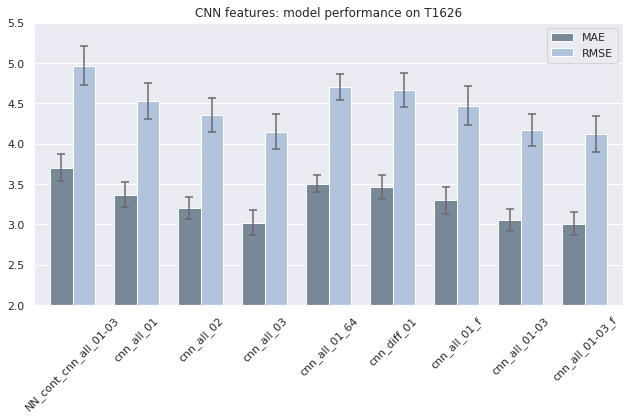

In [0]:
plot_results_bar_err(results_df=values_df,std_df=std_df,title="CNN features: model performance on T1626",saveloc=model_folder_loc+"cnn_features_performance.png", fig_size=(9,6), fig_lim=(2,5.5))

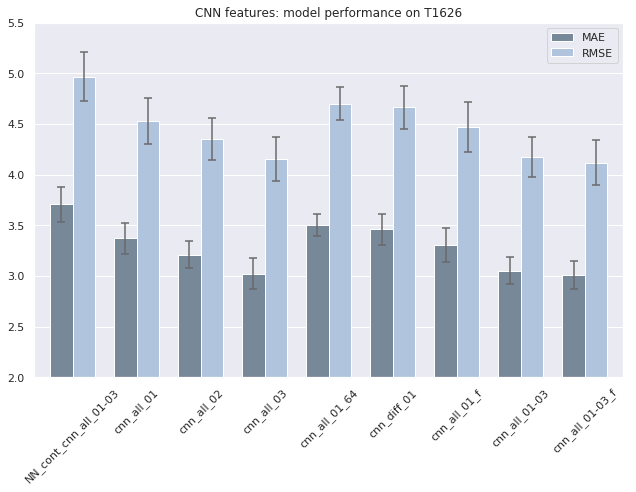

In [0]:
plot_results_bar_err(results_df=values_df,std_df=std_df,title="CNN features: model performance on T1626",saveloc=model_folder_loc+"cnn_features_performance_tall.png", fig_size=(9,7), fig_lim=(2,5.5))

In [0]:
std_df.columns = list(map(lambda x: x+"_std",std_df.columns))
results = pd.concat([values_df,std_df], axis=1)

In [0]:
results

,MAE,RMSE,MAE_std,RMSE_std
NN_cont_cnn_all_01-03,3.705597,4.968560,0.170001,0.245597
cnn_all_01,3.370267,4.529392,0.156376,0.222635
cnn_all_02,3.207712,4.355914,0.134344,0.207330
cnn_all_03,3.020594,4.151499,0.153916,0.218680
cnn_all_01_64,3.505535,4.701656,0.108799,0.160394
cnn_diff_01,3.459877,4.663660,0.150189,0.211770
cnn_all_01_f,3.300612,4.472187,0.168309,0.245293
cnn_all_01-03,3.052349,4.175051,0.133152,0.198492
cnn_all_01-03_f,3.008417,4.115874,0.142156,0.223138


In [0]:
results.to_csv(model_folder_loc+"cnn_features_results_table.csv")

### Visualization NEW


In [0]:
model = ["NN_A13","A1","A2","A3","D1","A1_f","A13","A13_f"]
value = [[3.705597,4.968560],
         [3.370267,4.529392],
         [3.207712,4.355914],
         [3.020594,4.151499],
         [3.459877,4.663660],
         [3.300612,4.472187],
         [3.052349,4.175051],
         [3.008417,4.115874]]
std = [[0.170001,0.245597],
       [0.156376,0.222635],
       [0.134344,0.207330],
       [0.153916,0.218680],
       [0.150189,0.211770],
       [0.168309,0.245293],
       [0.133152,0.198492],
       [0.142156,0.223138]]
measure = ["MAE","RMSE"]

values_df = pd.DataFrame(value)
values_df.columns=measure
values_df.index=model

std_df = pd.DataFrame(std)
std_df.columns=measure
std_df.index=model

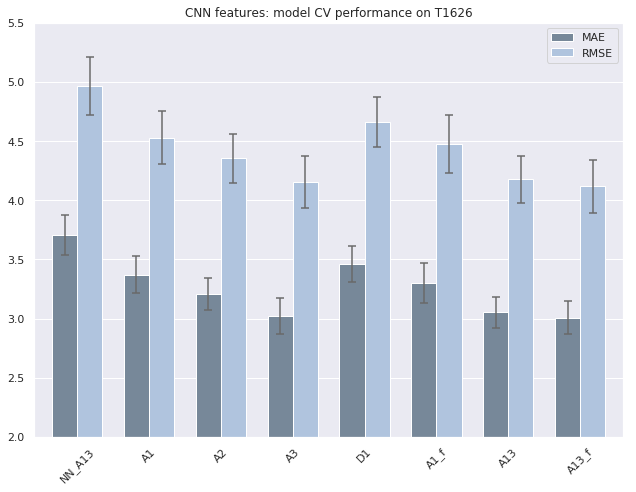

In [0]:
plot_results_bar_err(results_df=values_df,std_df=std_df,title="CNN features: model CV performance on T1626",saveloc=model_folder_loc+"cnn_features_performance_tall_NEW.png", fig_size=(9,7), fig_lim=(2,5.5))

In [0]:
std_df.columns = list(map(lambda x: x+"_std",std_df.columns))
results = pd.concat([values_df,std_df], axis=1)
results = results.round(3)

In [0]:
results

,MAE,RMSE,MAE_std,RMSE_std
NN_A13,3.706,4.969,0.170,0.246
A1,3.370,4.529,0.156,0.223
A2,3.208,4.356,0.134,0.207
A3,3.021,4.151,0.154,0.219
D1,3.460,4.664,0.150,0.212
A1_f,3.301,4.472,0.168,0.245
A13,3.052,4.175,0.133,0.198
A13_f,3.008,4.116,0.142,0.223


In [0]:
results.to_csv(model_folder_loc+"cnn_features_results_table_NEW.csv")

### Visualization NEW V2


In [0]:
model = ["A1","A2","A3","D1","A1_f","A13","A13_f"]
value = [[3.370267,4.529392],
         [3.207712,4.355914],
         [3.020594,4.151499],
         [3.459877,4.663660],
         [3.300612,4.472187],
         [3.052349,4.175051],
         [3.008417,4.115874]]
std = [[0.156376,0.222635],
       [0.134344,0.207330],
       [0.153916,0.218680],
       [0.150189,0.211770],
       [0.168309,0.245293],
       [0.133152,0.198492],
       [0.142156,0.223138]]
measure = ["MAE","RMSE"]

values_df = pd.DataFrame(value)
values_df.columns=measure
values_df.index=model

std_df = pd.DataFrame(std)
std_df.columns=measure
std_df.index=model

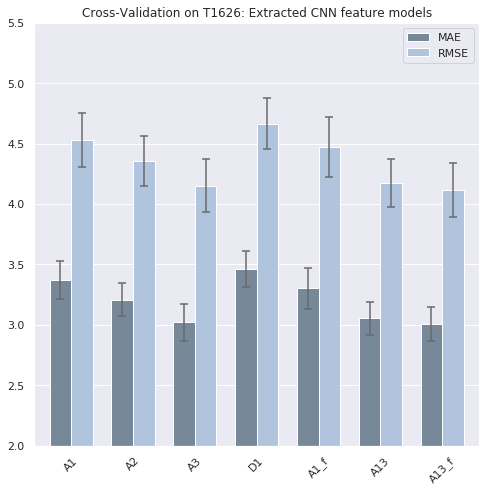

In [0]:
plot_results_bar_err(results_df=values_df,std_df=std_df,title="Cross-Validation on T1626: Extracted CNN feature models",saveloc=model_folder_loc+"cnn_features_performance_tall_NEW_V2.png", fig_size=(7,7), fig_lim=(2,5.5))

In [0]:
std_df.columns = list(map(lambda x: x+"_std",std_df.columns))
results = pd.concat([values_df,std_df], axis=1)
results = results.round(3)

In [0]:
results

,MAE,RMSE,MAE_std,RMSE_std
A1,3.370,4.529,0.156,0.223
A2,3.208,4.356,0.134,0.207
A3,3.021,4.151,0.154,0.219
D1,3.460,4.664,0.150,0.212
A1_f,3.301,4.472,0.168,0.245
A13,3.052,4.175,0.133,0.198
A13_f,3.008,4.116,0.142,0.223


In [0]:
results.to_csv(model_folder_loc+"cnn_features_results_table_NEW_V2.csv")